In [1]:
from glob import glob
import json
import random
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from ISLP.torch import SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers
from ISLP.torch.imdb import load_lookup, load_tensor, load_sparse, load_sequential
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import MeanAbsoluteError, R2Score
from torchinfo import summary
from torchvision.io import read_image
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import Resize, Normalize, CenterCrop, ToTensor

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.use_deterministic_algorithms(True, warn_only=True)

## 10.9 Lab: Deep Learning

### 10.9.1 Single Layer Network on Hitters Data

We fit two linear models on the `Hitters` data (least squares and lasso) and compare their performance to that of a neural network. We use mean absolute error on a validation dataset. Out goal is to preict the `Salary` of a baseball player in 1987 using his performance statistics from 1986.

In [10]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]

In [11]:
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy() # Needed to use sklearn to fit the lasso model

In [12]:
# Train-test split
(X_train,
 X_test,
 Y_train,
 Y_test) = train_test_split(X,
                            Y,
                            test_size=1/3,
                            random_state=1)

In [13]:
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


#### Linear models

We fit the linear model and evaluate the test error directly.

In [14]:
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test  = hit_lm.predict(X_test)
# Calculate the test error
np.abs(Yhat_test - Y_test).mean()

259.7152883314631

We use `sklearn` to fit a Lasso regression model (linear model trained with L1 as regularisation). We use the mean absolute error to select and evaluate a model, rather than the mean squared error.

We create a pipeline with two steps: 
* normalise the features using a `StandardScaler()`
* fit the lasso

In [15]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])

We choose a grid of 100 values for the penalty term $\lambda$, uniform on th elg scale from `lam_max` down to `0.01*lam_max`. 

`lam_max` is the smallest value of $\lambda$ with an all-zero solution.

In [16]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100)) * lam_max}

We perform cross-validation using this set of $\lambda$ values.

In [17]:
cv = KFold(
    10,
    shuffle=True,
    random_state=1,
)

grid = GridSearchCV(
    lasso, 
    param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error'
)
grid.fit(X_train, Y_train);

We extract the lasso model with the best cross-validated mean absolute error and evaluate its performance on `X_test` and `Y_test`.

In [18]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

257.23820107995

This is very similar to the MAE of the linear least squares model we fitted earlier, although the result will depend heavily on the train/test split used.

#### Specifying a network: classes and inheritance

To fit the neural network, we first set up a model structure which describes the network. In `pytorch`, this is typically done by sub-classing a generic representation of a network.

In [19]:
class HittersModel(nn.Module):

    def __init__(self, input_size):
        super(HittersModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [21]:
X.shape

(263, 19)

In [20]:
hit_model = HittersModel(X.shape[1])

In [22]:
summary(
    hit_model,
    input_size=X_train.shape,
    col_names=[
        'input_size',
        'output_size',
        'num_params']
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

We need to transform our training data into a form accessible to `torch`. The basic datatype in `torch` is `tensor`, which is similar to an `ndarray`. Because `torch` typically works with 32-bit rather than 64-bit floats, we covert our data to `np.float32` before forming the tensor.

In [24]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)

This dataset is passed to a `DataLoader()` which passed the data into our network. the `ISLP` library contains the `SimpleDataModule()` function, which takes `num_workers` (how many processes we wil use for loading the data) as an argument.

We use the included `rec_num_workers()` function to set a reasonable max number of workers.

In [26]:
max_num_workers = rec_num_workers()
max_num_workers

12

The general training setup in pytorch_lightning involves training, validation and test data. These are each represented by different data loaders. During each epoch, we run a training step to learn the model and a validation step to track the error. The test data is typically used at the end of training to evaluate the model.

In this case, as we had split only into test and training, we’ll use the test data as validation data with the argument `validation=hit_test`. The `validation` argument can be a float between 0 and 1, an integer, or a `Dataset` . If a float (respectively, integer), it is interpreted as a percentage (respectively number) of the training observations to be used for validation. If it is a `Dataset`, it is passed directly to a data loader.

In [27]:
hit_dm = SimpleDataModule(
    hit_train,
    hit_test,
    batch_size=32,
    num_workers=min(4, max_num_workers),
    validation=hit_test
)

We need to provide a `pytorch_lightning` module that controls the steps performed during the training process. By using the `SimpleModule.regression()` method, we indicate that we will use squared-error loss. We also ask for mean absolute error to be tracked in the metrics that are logged.

In [29]:
hit_module = SimpleModule.regression(
    hit_model,
    metrics={
        'mae': MeanAbsoluteError()
    }
);

We log our results via CSVLogger(), which stores the results in a CSV file within a directory `logs/hitters`. After the fitting is complete, this allows us to load the results as a `pd.DataFrame()` and visualise them.

In [30]:
hit_logger = CSVLogger('logs', name='hitters')

We use the `Trainer()` object from `pytorch_lightning` to train the model.

`datamodule=hit_dm` tells the trainer how training/validation/test logs are produced.

The `hit_module` argument specifies the network architeture as well as the training/validation/test steps.

The `callbacks` argument allows for several tasks to be carrier out at various points while training a model.

The `ErrorTracker()` callback allows us to compute validation error while training and finally, the test error.

We fit the model for 50 epochs.

In [31]:
hit_trainer = Trainer(
    deterministic=True,
    max_epochs=50,
    log_every_n_steps=5,
    logger=hit_logger,
    callbacks=[ErrorTracker()]
)
hit_trainer.fit(hit_module, datamodule=hit_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/hitters

  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 121.19it/s, v_num=0]           

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 114.19it/s, v_num=0]


We can evaluate performance on our tst data using the `test()` method of the trainer.

In [32]:
hit_trainer.test(hit_module, datamodule=hit_dm)

Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 194.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             104098.5703125
        test_mae            229.50115966796875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 104098.5703125, 'test_mae': 229.50115966796875}]

We can create a plot of the MAE as a function of the number of epochs.

In [33]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [34]:
def summary_plot(
    results,
    ax,
    col='loss',
    valid_legend='Validation',
    training_legend='Training',
    ylabel='Loss',
    fontsize=20
):
    for (column, color, label) in zip(
        [f'train_{col}_epoch', f'valid_{col}'],
        ['black', 'red'],
        [training_legend, valid_legend]
    ):
        results.plot(
            x='epoch',
            y=column,
            label=label,
            marker='o',
            color=color,
            ax=ax
        )
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

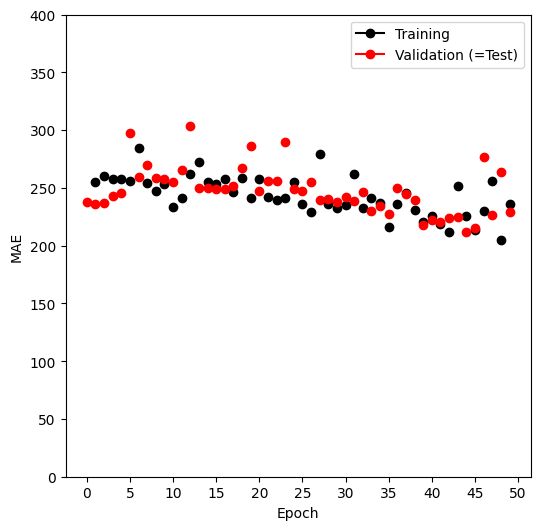

In [36]:
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(
    hit_results,
    ax,
    col='mae',
    ylabel='MAE',
    valid_legend='Validation (=Test)'
)
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

We can predict directly from the final moel and evaluate its performance on the test data. By calling `eval()` first, we tell `torch` to consider the model to be fitted so that we can use it to predict on new data. The dropout layers will be turned off, i.e. no weights will be randomly dropped in predicting on new data.

In [37]:
hit_model.eval()
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(229.5012, grad_fn=<MeanBackward0>)

This is an improvement on both our OLS model and our lasso regression model.

Finally, we cleanup the worker processes that we initiated by deleting references to their torch objects.

In [38]:
del(
    Hitters,
    hit_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    hit_trainer, hit_module
)